In [1]:
!pip install tqdm==4.19.9
!pip install shapely
!pip install imutils
!pip install tripy
!pip install simplekml

import cv2
import math
import os
import sys
import time
import numpy as np
import skimage.io
from skimage.transform import rescale, resize, downscale_local_mean
from skimage.measure import label, regionprops

from scipy.spatial import distance

from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools import mask as maskUtils

import coco #a slightly modified version

from mrcnn.evaluate import build_coco_results, evaluate_coco
from mrcnn.dataset import MappingChallengeDataset
from mrcnn import visualize

import zipfile
import urllib.request
import shutil
import glob
import tqdm
import random
from matplotlib import pyplot as plt
import imutils

import shapely
from shapely.geometry import Polygon
from shapely.ops import split

import tripy
import json

from shapely.geometry import LineString, Point

from pycocotools.coco import COCO
from PIL import Image

import simplekml

ROOT_DIR = os.getcwd()

You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 18.1, however version 20.3.4 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Using TensorFlow backend.


# Initialization

In [2]:
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils


# PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "pretrained_weights.h5")
PRETRAINED_MODEL_PATH = os.path.join(ROOT_DIR,"data/" "mask_rcnn_crowdai-mapping-challenge_0069.h5")
LOGS_DIRECTORY = os.path.join(ROOT_DIR, "logs")
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
IMAGE_DIR = os.path.join(ROOT_DIR, "data", "test", "images")


class InferenceConfig(coco.CocoConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    IMAGES_PER_GPU = 1
    
    MAX_GT_INSTANCES = 50
    POST_NMS_ROIS_INFERENCE = 500
    POST_NMS_ROIS_TRAINING = 1000

    # Uncomment to train on 8 GPUs (default is 1)
    GPU_COUNT = 1
    
    BACKBONE = "resnet101"

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # 1 Backgroun + 1 Building

    STEPS_PER_EPOCH=1000
    VALIDATION_STEPS=50
    
    IMAGE_MAX_DIM=320
    IMAGE_MIN_DIM=320
    NAME = "crowdai-mapping-challenge"
    
config = InferenceConfig()
config.display()



model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)
model_path = PRETRAINED_MODEL_PATH
model.load_weights(model_path, by_name=True)
class_names = ['BG', 'building'] # In our case, we have 1 class for the background, and 1 class for building


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  320
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               50
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           crowdai-mapping-challenge
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE

# Utility Methods

In [3]:
def distance(p1, p2):
    return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

def removeBoundaryPredicitions(p):

    temp = {}

    rois = p['rois']
    masks = p['masks']
    class_ids = p['class_ids']
    scores = p['scores']

    remove_indexes = []

    for i in range(len(rois)):

        roi = rois[i]
        leftY = roi[0]
        leftX = roi[1]
        rightY = roi[2]
        rightX = roi[3]

        if(leftY <= 2) or (rightY >= 254) or (leftX <= 2) or (rightX >= 254):
            remove_indexes.append(i)


    temp['rois'] = np.delete(p['rois'], remove_indexes, axis=0)
    temp['masks'] = np.delete(p['masks'], remove_indexes, axis=2)
    temp['class_ids'] = np.delete(p['class_ids'], remove_indexes, axis=0)
    temp['scores'] = np.delete(p['scores'], remove_indexes, axis=0)
    
    return temp


def roundToNearestPowerOf2(val):
    result = 0
    
    prev_diff = val - result
    
    while(1):
        result += 256
        diff = val - result
        if(diff < 0):
            diff = -1*diff
        
        if diff < prev_diff:
            prev_diff = diff
        else:
            result -= 256
            break
        
    
    return result


def getImageData(image):
    imgheight=roundToNearestPowerOf2(image.shape[0])
    imgwidth=roundToNearestPowerOf2(image.shape[1])

    M = 256
    N = 256
    
    masks = []
    
    new_image = np.zeros((imgheight, imgwidth, 3))

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            patch = image[y:y+M,x:x+N]

            predictions = model.detect([patch]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

            p = predictions[0]
            p = removeBoundaryPredicitions(p)
            
            img = visualize.display_instances(patch, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
            
            image_resized = resize(img, (256, 256))
            new_image[y:y+M,x:x+N] = image_resized

            for i in range(p['masks'].shape[2]):
                mask = p['masks'][:, :, i]
                
                #get minimum enclosing rectangle for mask
                mask_img = mask.astype(np.uint8)
                res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
                
                if contours:
                    cnt = contours[0]
                    rect = cv2.minAreaRect(cnt)
                    box = cv2.boxPoints(rect)
                    box = np.int0(box)

                    for i in range(len(box)):
                        box[i][0] = box[i][0] + x
                        box[i][1] = box[i][1] + y

                    masks.append(box)

                    mask_img = label(mask, connectivity=mask_img.ndim)
                    regions = regionprops(mask_img)

                    for props in regions:
                        minr, minc, maxr, maxc = props.bbox

    plt.figure()
    plt.imshow(image)

    return masks, new_image


def getRotatedImageData(image, file_name):
    imgheight=roundToNearestPowerOf2(image.shape[0])
    imgwidth=roundToNearestPowerOf2(image.shape[1])

    M = 256
    N = 256
    
    total_width = 0
    total_length = 0
    total_masks = 0
    masks = []
    
    new_image = np.zeros((imgheight, imgwidth, 3))

    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            patch = image[y:y+M,x:x+N]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:

                predictions = model.detect([patch]*config.BATCH_SIZE, verbose=1) # We are replicating the same image to fill up the batch_size

                p = predictions[0]
                p = removeBoundaryPredicitions(p)

                img = visualize.display_instances(patch, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
                image_resized = resize(img, (256, 256))
                new_image[y:y+M,x:x+N] = image_resized

                for i in range(p['masks'].shape[2]):
                    mask = p['masks'][:, :, i]

                    #get minimum enclosing rectangle for mask
                    mask_img = mask.astype(np.uint8)
                    res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

                    if contours:
                        total_masks += 1

                        cnt = contours[0]
                        rect = cv2.minAreaRect(cnt)
                        box = cv2.boxPoints(rect)
                        box = np.int0(box)

                        for i in range(len(box)):
                            box[i][0] = box[i][0] + x
                            box[i][1] = box[i][1] + y

                        masks.append(box)

                        mask_img = label(mask, connectivity=mask_img.ndim)
                        regions = regionprops(mask_img)

                        for props in regions:
                            minr, minc, maxr, maxc = props.bbox

                            total_width += (maxc - minc)
                            total_length += (maxr - minr)
    plt.figure()
    plt.imshow(image)
    
#     skimage.io.imsave("./rotated_results/"+file_name+".jpg", new_image)

    return total_width/int(total_masks), total_length/int(total_masks), masks, new_image



def rotate_box(bb, cx, cy, h, w, theta):
    new_bb = list(bb)
    for i,coord in enumerate(bb):
        # opencv calculates standard transformation matrix
        M = cv2.getRotationMatrix2D((cx, cy), theta, 1.0)
        # Grab  the rotation components of the matrix)
        cos = np.abs(M[0, 0])
        sin = np.abs(M[0, 1])
        # compute the new bounding dimensions of the image
        nW = int((h * sin) + (w * cos))
        nH = int((h * cos) + (w * sin))
        # adjust the rotation matrix to take into account translation
        M[0, 2] += (nW / 2) - cx
        M[1, 2] += (nH / 2) - cy
        # Prepare the vector to be transformed
        v = [coord[0],coord[1],1]
        # Perform the actual rotation and return the image
        calculated = np.dot(M,v)
        new_bb[i] = (calculated[0],calculated[1])
    return new_bb


def rotate_point(image, coord, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), -1*angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    v = [coord[0],coord[1],1]
    # Perform the actual rotation and return the image
    calculated = np.dot(M,v)
    new_bb = (int(calculated[0]),int(calculated[1]))
    
    return new_bb

def rotate_point_inverse(image, coord, angle):
    # grab the dimensions of the image and then determine the
    # center
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)
    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])
    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))
    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY
    
    M = np.append(M, [[0, 0, 1]], axis=0)
    v = [coord[0],coord[1],1]
    
    M_inv = np.linalg.inv(M)
    # Perform the actual rotation and return the image
    calculated = np.dot(M_inv,v)
    new_bb = (int(calculated[0]),int(calculated[1]))
    
    return new_bb

def rotate_bound(image, angle):
    # grab the dimensions of the image and then determine the
    # centre
    (h, w) = image.shape[:2]
    (cX, cY) = (w // 2, h // 2)

    # grab the rotation matrix (applying the negative of the
    # angle to rotate clockwise), then grab the sine and cosine
    # (i.e., the rotation components of the matrix)
    M = cv2.getRotationMatrix2D((cX, cY), angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])

    # compute the new bounding dimensions of the image
    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))

    # adjust the rotation matrix to take into account translation
    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    # perform the actual rotation and return the image
    return cv2.warpAffine(image, M, (nW, nH))


def findRotationAngle(image, a, b):

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))
    
    line_length = distance(a, b)
    shape = image.shape
    
    r_a = a
    r_b = (a[0] + line_length, a[1])
    
    l1 = [a, b]
    l2 = [r_a, r_b]
    
    m1 = (b[1] - a[1])/(b[0] - a[0])
    m2 = (r_b[1] - r_a[1])/(r_b[0] - r_a[0])

    angle1 = math.atan(m1)
    angle2 = math.atan(m2)
    
    angle_deg = (angle2-angle1)*180/math.pi
    
    return angle_deg


def getRotatedImageAndDividingLine(img_org, a, b):
    theta = findRotationAngle(img_org, a, b)

    rotated_img = imutils.rotate_bound(img_org, -1*theta)

    heigth, width = img_org.shape[:2]
    (cx, cy) = (width // 2, heigth // 2)

    bb1 = {}
    bb1[0] = [a, b]

    new_bb = {}
    for i in bb1:
        new_bb[i] = rotate_box(bb1[i], cx, cy, heigth, width, -1*theta)

    r_a = (int(new_bb[0][0][0]), int(new_bb[0][0][1]))
    r_b = (int(new_bb[0][1][0]), int(new_bb[0][1][1]))
    
    return rotated_img, r_a, r_b, theta


def rotatebbox(img_org, theta, bbox):
    heigth, width = img_org.shape[:2]
    (cx, cy) = (width // 2, heigth // 2)

    bb1 = {}
    bb1[0] = bbox

    new_bb = {}
    for i in bb1:
        new_bb[i] = rotate_box(bb1[i], cx, cy, heigth, width, -1*theta)

    r_a = (int(new_bb[0][0][0]), int(new_bb[0][0][1]))
    r_b = (int(new_bb[0][1][0]), int(new_bb[0][1][1]))
    r_c = (int(new_bb[0][2][0]), int(new_bb[0][2][1]))
    r_d = (int(new_bb[0][3][0]), int(new_bb[0][3][1]))
    
    r_bbox = [r_a, r_b, r_c, r_d]
    
    return r_bbox

# Grid Estimation Methods

In [4]:
def getAdjustedParallelLinesAndCost(image, w, point1, point2, total_divisions, masks, end_point1):
    cost = 0
    points = []
    
    while(point1[0] > end_point1[0]):
        line_point1 = list(point1)
        new_1 = line_point1[0] - w

        line_point2 = list(point2)
        new_2 = line_point2[0] - w

        line_point1[0] = new_1
        line_point2[0] = new_2
        
        if line_point1[0] <= end_point1[0]:
            break

        line_point1 = tuple(line_point1)
        line_point2 = tuple(line_point2)
        
        new_point1, new_point2 = getAdjustedLineCoordinates(line_point1, line_point2, masks)
        
#         cv2.line(image,new_point1,new_point2,(255,0,0),5)
        
        c = calculateLineCost(new_point1, new_point2, masks)
        cost += c

        point1 = line_point1
        point2 = line_point2
        
        points.append(new_point1[0])
        
    return cost, points



def drawMasks(img, masks):
    for m in masks:
        cv2.drawContours(img,[m],0,(0,0,255),5)
        
        
def getParallelLinesAndCost(image, w, start_point1, start_point2, total_divisions, masks, end_point1):
    cost = 0
    print(end_point1[0])
    while(start_point1[0] > end_point1[0]):
#     for i in range(total_divisions - 1):
        start_point1 = list(start_point1)
        new_1 = start_point1[0] - w

        start_point2 = list(start_point2)
        new_2 = start_point2[0] - w
        
        start_point1[0] = new_1
        start_point2[0] = new_2
        
        if start_point1[0] <= end_point1[0]:
            break

        start_point1 = tuple(start_point1)
        start_point2 = tuple(start_point2)

        c = calculateLineCost(start_point1, start_point2, masks)
        cost += c
        
#         cv2.line(image,start_point1,start_point2,(0,0,255),5)
        
    return cost


def calculateLineCost(a, b, masks):
    cost = 0
    
    for m in masks:
        cost += findIntersections(m, a)
                
    return cost
         
    
def findIntersections(m, a):
    cost = 0
    
    #starting point of mask is behind the line
    if m[0][0] < a[0]:
        if m[1][0] < a[0]:
            if (a[0] > m[1][0]) and (a[0] < m[2][0]):
                mid = int((m[2][0] - m[1][0])/2)
                mid = m[1][0] + mid
                
                if a[0] >= mid:
                    cost += m[2][0] - a[0]
                else:
                    cost += a[0] - m[1][0]
                
        else:
            if (a[0] > m[0][0]) and (a[0] < m[1][0]):
                mid = int((m[1][0] - m[0][0])/2)
                mid = m[0][0] + mid
                
                if a[0] >= mid:
                    cost += m[1][0] - a[0]
                else:
                    cost += a[0] - m[0][0]
    # after the line
    else:
        if m[1][0] > a[0]:
            if (a[0] > m[2][0]) and (a[0] < m[1][0]):
                mid = int((m[1][0] - m[2][0])/2)
                mid = m[2][0] + mid
                
                if a[0] >= mid:
                    cost += m[1][0] - a[0]
                else:
                    cost += a[0] - m[2][0]
        else:
            if (a[0] > m[1][0]) and (a[0] < m[0][0]):
                mid = int((m[0][0] - m[1][0])/2)
                mid = m[1][0] + mid
                
                if a[0] >= mid:
                    cost += m[0][0] - a[0]
                else:
                    cost += a[0] - m[1][0]
                
    
    return cost



def getAdjustedLineCoordinates(a, b, masks):
    
    a = list(a)
    b = list(b)
    
    for m in masks:
        #starting point of mask is behind the line
        if m[0][0] < a[0]:
            if m[1][0] < a[0]:
                if (a[0] > m[1][0]) and (a[0] < m[2][0]):
                    mid = int((m[2][0] - m[1][0])/2)
                    mid = m[1][0] + mid

                    if a[0] >= mid:
                        a[0] = m[2][0]
                        b[0] = m[2][0]
                    else:
                        a[0] = m[1][0]
                        b[0] = m[1][0]

            else:
                if (a[0] > m[0][0]) and (a[0] < m[1][0]):
                    mid = int((m[1][0] - m[0][0])/2)
                    mid = m[0][0] + mid

                    if a[0] >= mid:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                    else:
                        a[0] = m[0][0]
                        b[0] = m[0][0]
                        
        # after the line
        else:
            if m[1][0] > a[0]:
                if (a[0] > m[2][0]) and (a[0] < m[1][0]):
                    mid = int((m[1][0] - m[2][0])/2)
                    mid = m[2][0] + mid

                    if a[0] >= mid:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                    else:
                        a[0] = m[2][0]
                        b[0] = m[2][0]
            else:
                if (a[0] > m[1][0]) and (a[0] < m[0][0]):
                    mid = int((m[0][0] - m[1][0])/2)
                    mid = m[1][0] + mid

                    if a[0] >= mid:
                        a[0] = m[0][0]
                        b[0] = m[0][0]
                    else:
                        a[0] = m[1][0]
                        b[0] = m[1][0]
                        
    return tuple(a),tuple(b)


def pointOfInteresection(A, B, C, D):
    
    line1 = LineString([A, B])
    line2 = LineString([C, D])

    int_pt = line1.intersection(line2)
    return int_pt



def estimateGrid(file_name, r_image, w, l, masks, a, b):

    plt.figure()
    plt.imshow(r_image)

#     image = skimage.io.imread("./rotated_results/"+file_name+".jpg")
#     image2 = skimage.io.imread("./rotated_results/"+file_name+".jpg")
#     image3 = skimage.io.imread("./rotated_results/"+file_name+".jpg")
    
    image = r_image
    image2 = r_image
    image3 = r_image
    
    shape = image.shape

    def distance(p1, p2):
        return int(math.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))

    block_length = distance(a, b)
    total_divisions = int(round(block_length/int(w)))

    cd_length = int(l*1.25)
    
    #get line perpendicular to the dividing line ab

    ab = LineString([a, b])
    left = ab.parallel_offset(cd_length, 'left')
    right = ab.parallel_offset(cd_length, 'right')

    c = left.boundary[1]
    d = right.boundary[0]  

    c = (int(c.x), int(c.y))
    d = (int(d.x), int(d.y))
    
    #get line perpendicular to the dividing line ba
    ba = LineString([b, a])
    left = ba.parallel_offset(cd_length, 'left')
    right = ba.parallel_offset(cd_length, 'right')

    e = left.boundary[1]
    f = right.boundary[0]  

    e = (int(e.x), int(e.y))
    f = (int(f.x), int(f.y))
    
    cv2.line(image3,a,b,(0,255,0),2)
    cv2.line(image3,c,d,(255,0,0),2)
    cv2.line(image3,e,f,(255,0,0),2)
    
    cost = getParallelLinesAndCost(image, int(w), c, d, total_divisions, masks, e)

#     print("Cost before line adjustment: ")
#     print(cost)

#     plt.figure()
#     plt.imshow(image)

    cost, points = getAdjustedParallelLinesAndCost(image2, int(w), c, d, total_divisions, masks, e)
#     print("Cost After line adjustment: ")
#     print(cost)
    
#     plt.figure()
#     plt.imshow(image2)
    
    #remove close lines and complete grid
    points_length = len(points)
    min_gap = int(0.30*w)
    
    new_points = []
    
    for i in range(points_length):
        if i+1 < points_length:
            diff = abs(points[i] - points[i+1])

            if diff > min_gap:
                x = points[i]
                point1 = (x, c[1])
                point2 = (x, d[1])
                
                new_points.append(x)
                cv2.line(image3,point1,point2,(255,0,0),2)
        else:
            new_points.append(points[i])
    
    
    cv2.line(image3,c,f,(255,0,0),2)
    cv2.line(image3,d,e,(255,0,0),2)
    
    plt.figure()
    plt.imshow(image3)
    
    boxes = []
    
    top_bound = c
    mid_bound = b
    bot_bound = d
    
    for x in new_points:
        boxes.append([top_bound, mid_bound, (x, mid_bound[1]), (x, top_bound[1])])
        boxes.append([mid_bound, bot_bound, (x, bot_bound[1]), (x, mid_bound[1])])
        
        top_bound = list(top_bound)
        diff = top_bound[0] - x
        top_bound[0] -= diff
        
        mid_bound = list(mid_bound)
        mid_bound[0] -= diff
        
        bot_bound = list(bot_bound)
        bot_bound[0] -= diff
        
        top_bound = tuple(top_bound)
        mid_bound = tuple(mid_bound)
        bot_bound = tuple(bot_bound)
    
            
    return boxes

def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

def getBoundingBoxCoordinates(coco_bb):
    [min_x, min_y, width, height] = coco_bb
    
    point1 = (min_x, min_y)
    point2 = (min_x + width, min_y)
    point3 = (min_x + width, min_y + height)
    point4 = (min_x, min_y + height)
    
    return [point1, point2, point3, point4]

# Read Block Data

In [1]:
def getFourDirectionData(image):
    #iterate over the image in 256x256 patches in four directions to get all possible masks
    #1. top-left to bottom-right
    #2. top-right to bottom-left
    #3. bottom-left to top-right
    #4. bottom-right to top-left
    
    imgheight=image.shape[0]
    imgwidth=image.shape[1]

    M = 256
    N = 256
    
    total_width = 0
    total_length = 0
    total_masks = 0
    masks = []
    
    area_threshold = 2000
    
#     new_image = np.zeros((imgheight, imgwidth, 3))
    
    for y in range(0, imgheight, M):
        for x in range(0, imgwidth, N):
            patch = image[y:y+M,x:x+N]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                width, length, box, image_resized = getMaskStats(patch, x, y)
#                 new_image[y:y+M,x:x+N] = image_resized
            
                if width > 0 and length > 0 and (width*length > area_threshold):
                    total_width += width
                    total_length += length
                    total_masks += 1
                    masks.append(box)

                    
#     plt.figure()
#     plt.imshow(new_image)
#     new_image = np.zeros((imgheight, imgwidth, 3))                    
    
    for y in range(imgheight, 0, -1*M):
        for x in range(imgwidth, 0, -1*N):
            patch = image[y-M:y,x-N:x]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                width, length, box, image_resized = getMaskStats(patch, x, y)
#                 new_image[y-M:y,x-N:x] = image_resized
                
                if width > 0 and length > 0 and (width*length > area_threshold):
                    total_width += width
                    total_length += length
                    total_masks += 1
                    masks.append(box)
                    
    
#     plt.figure()
#     plt.imshow(new_image)
#     new_image = np.zeros((imgheight, imgwidth, 3))        

    for y in range(0, imgheight, M):
        for x in range(imgwidth, 0, -1*N):
            patch = image[y:y+M,x-N:x]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                width, length, box, image_resized = getMaskStats(patch, x, y)
#                 new_image[y:y+M,x-N:x] = image_resized
                
                if width > 0 and length > 0 and (width*length > area_threshold):
                    total_width += width
                    total_length += length
                    total_masks += 1
                    masks.append(box)
                    
    
#     plt.figure()
#     plt.imshow(new_image)
#     new_image = np.zeros((imgheight, imgwidth, 3))

    for y in range(imgheight, 0, -1*M):
        for x in range(0, imgwidth, N):
            patch = image[y-M:y,x:x+N]
            
            if patch.shape[0] == 256 and patch.shape[1] == 256:
                width, length, box, image_resized = getMaskStats(patch, x, y)
#                 new_image[y-M:y,x:x+N] = image_resized
   
                if width > 0 and length > 0 and (width*length > area_threshold):
                    total_width += width
                    total_length += length
                    total_masks += 1
                    masks.append(box)
                
    
#     plt.figure()
#     plt.imshow(new_image)
#     new_image = np.zeros((imgheight, imgwidth, 3))
    
    if total_masks == 0:
        return 0,0,[]
    else:
        return total_width/int(total_masks), total_length/int(total_masks), masks
    
def getMaskStats(patch, xm, ym):
    predictions = model.detect([patch]*config.BATCH_SIZE, verbose=0)
    
    p = predictions[0]
    p = removeBoundaryPredicitions(p)
    
#     print(p)
    
    width = 0
    length = 0
    box = 0
    image_resized = 0

#     img = visualize.display_instances(patch, p['rois'], p['masks'], p['class_ids'], class_names, p['scores'])
#     image_resized = resize(img, (256, 256))
    image_resized = np.zeros((imgheight, imgwidth, 3))

    for i in range(p['masks'].shape[2]):
        mask = p['masks'][:, :, i]

        #get minimum enclosing rectangle for mask
        mask_img = mask.astype(np.uint8)
        res, contours, _ = cv2.findContours(mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

        if contours:
            cnt = contours[0]
            rect = cv2.minAreaRect(cnt)
            
            box = cv2.boxPoints(rect)
            box = np.int0(box)
            
            for i in range(len(box)):
                box[i][0] = box[i][0] + xm
                box[i][1] = box[i][1] + ym

            mask_img = label(mask, connectivity=mask_img.ndim)
            regions = regionprops(mask_img)

            for props in regions:
                minr, minc, maxr, maxc = props.bbox
                width = (maxc - minc)
                length = (maxr - minr)
                
    return width, length, box, image_resized

def LatLontoXY(lat_center, lon_center, zoom):
    C = (256/(2*math.pi)) * 2**zoom

    x = C*(math.radians(lon_center)+math.pi)
    y = C*(math.pi-math.log(math.tan((math.pi/4) + math.radians(lat_center)/2)))

    return x, y


def xy2LatLon(lat_center, lon_center, zoom, width_internal, height_internal, pxX_internal, pxY_internal):

    xcenter, ycenter = LatLontoXY(lat_center, lon_center, zoom)

    xPoint = xcenter - (width_internal/2-pxX_internal)
    ypoint = ycenter - (height_internal/2-pxY_internal)

    C = (256 / (2 * math.pi)) * 2 ** zoom
    M = (xPoint/C)-math.pi
    N = -(ypoint/C) + math.pi

    lon_Point = math.degrees(M)
    lat_Point = math.degrees((math.atan(math.e**N)-(math.pi/4))*2)

    return (lat_Point, lon_Point)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
block_8.jpg
50
total_boxes
26
total_anns
24
total_iou
10.928525762576545
average_iou
0.455355240107356


<Figure size 432x288 with 0 Axes>

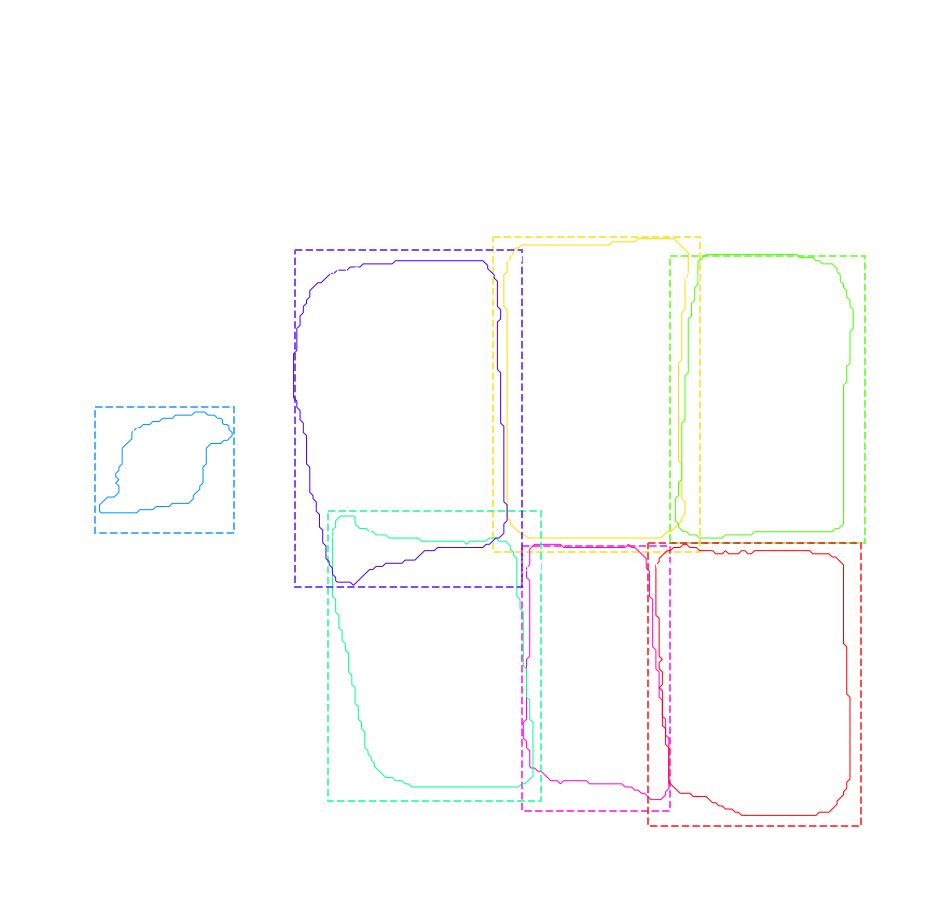

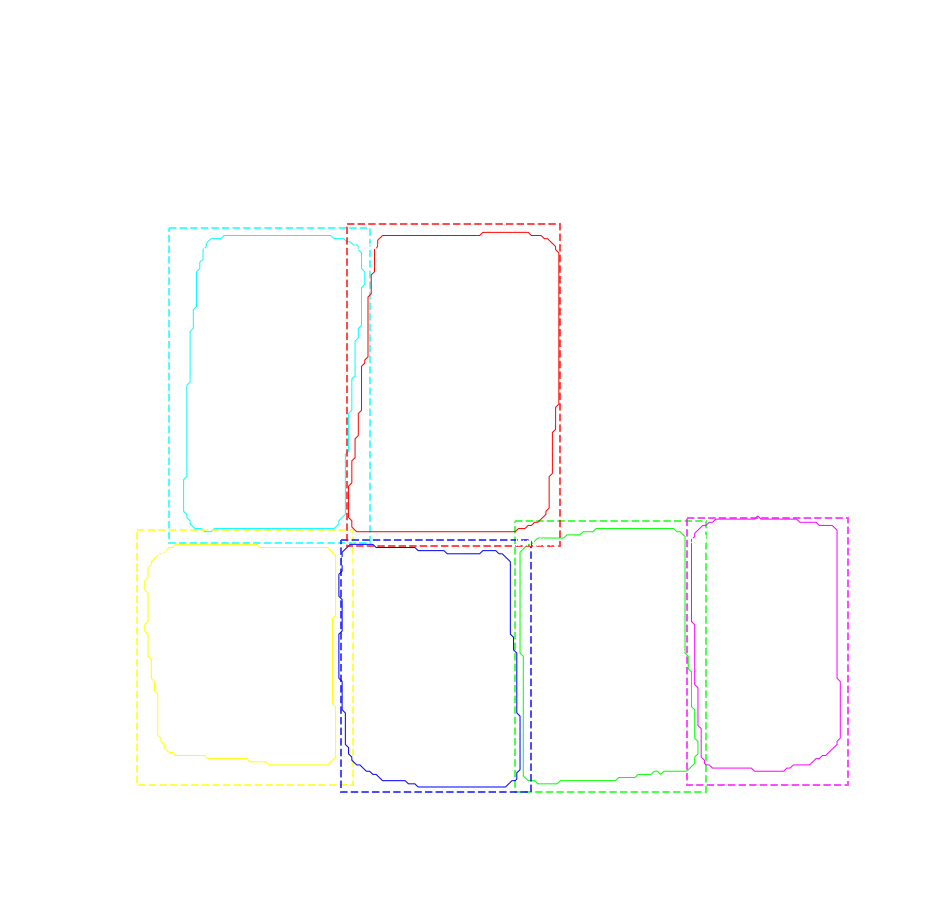

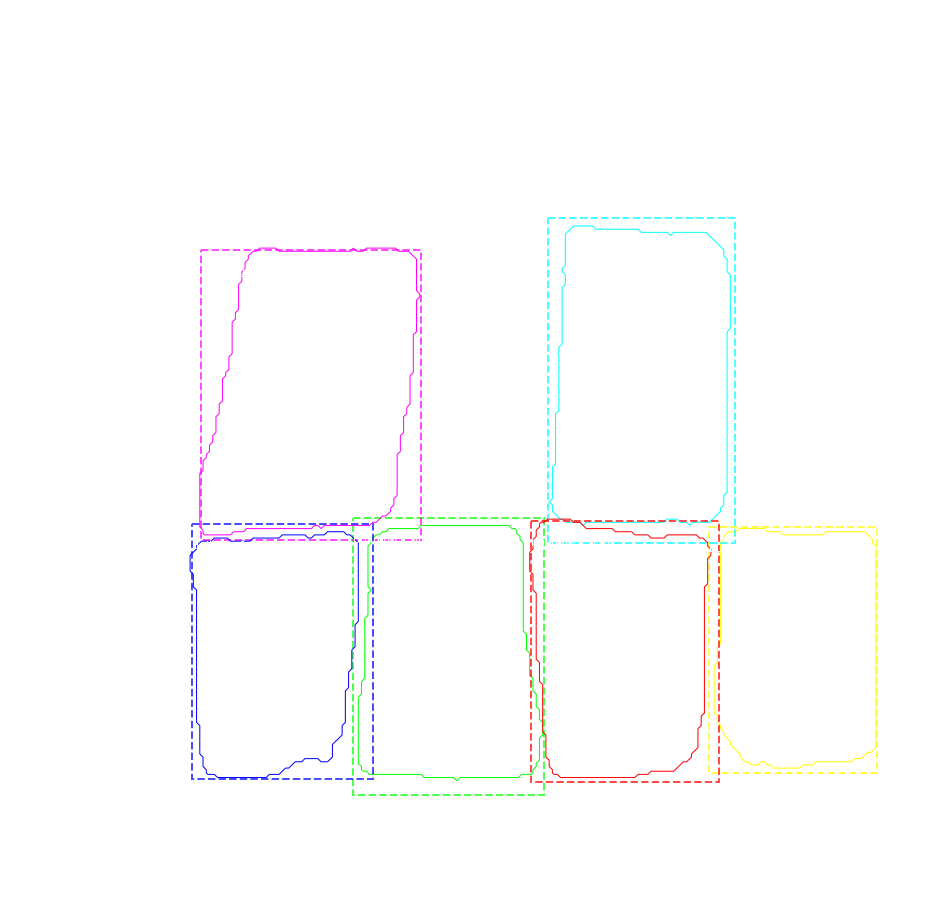

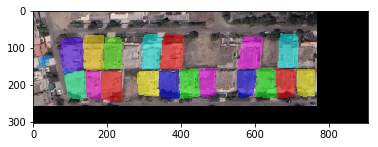

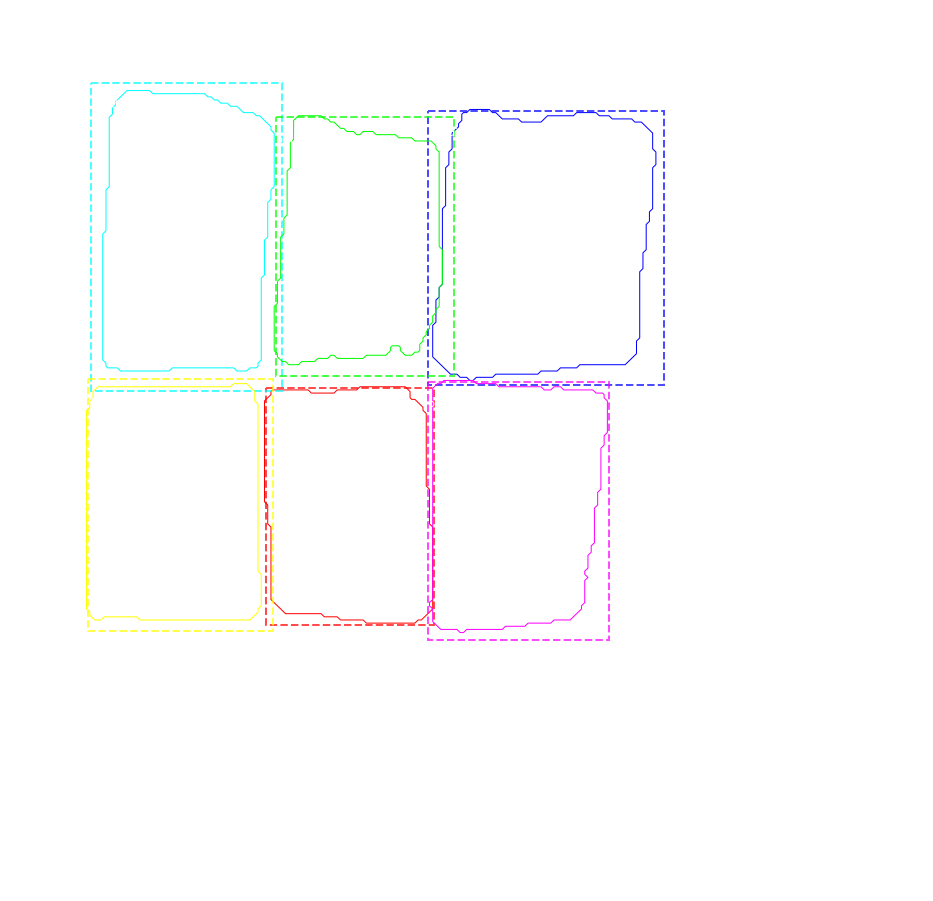

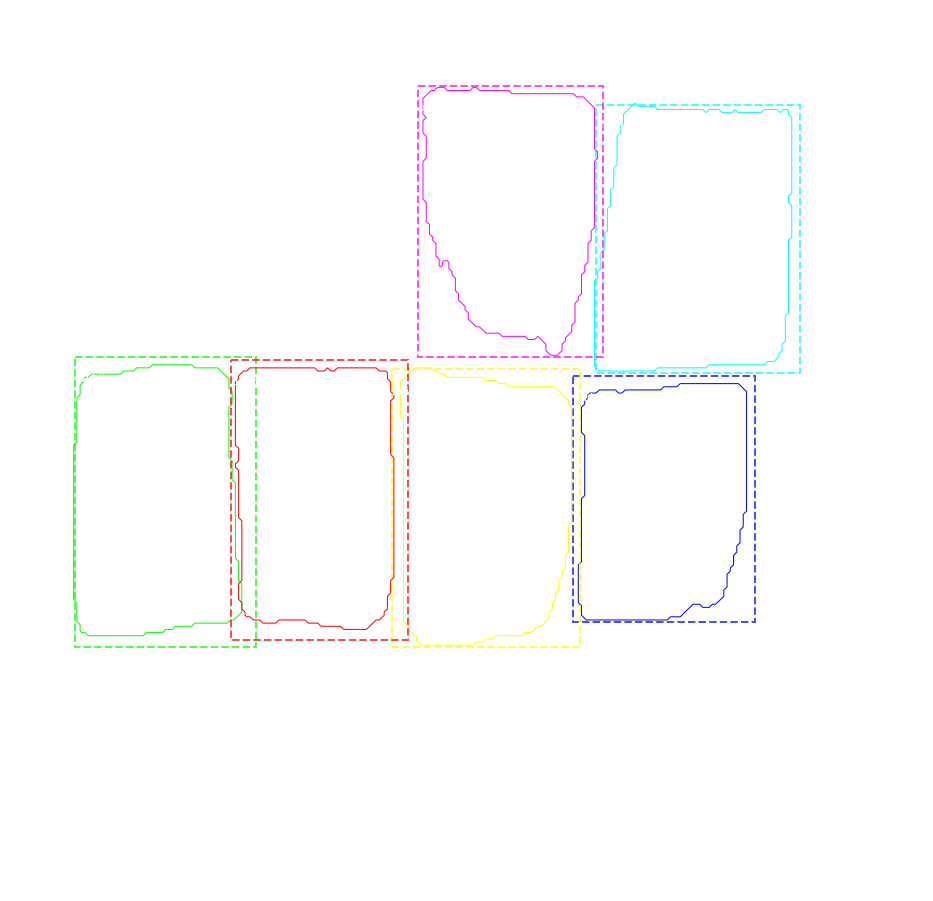

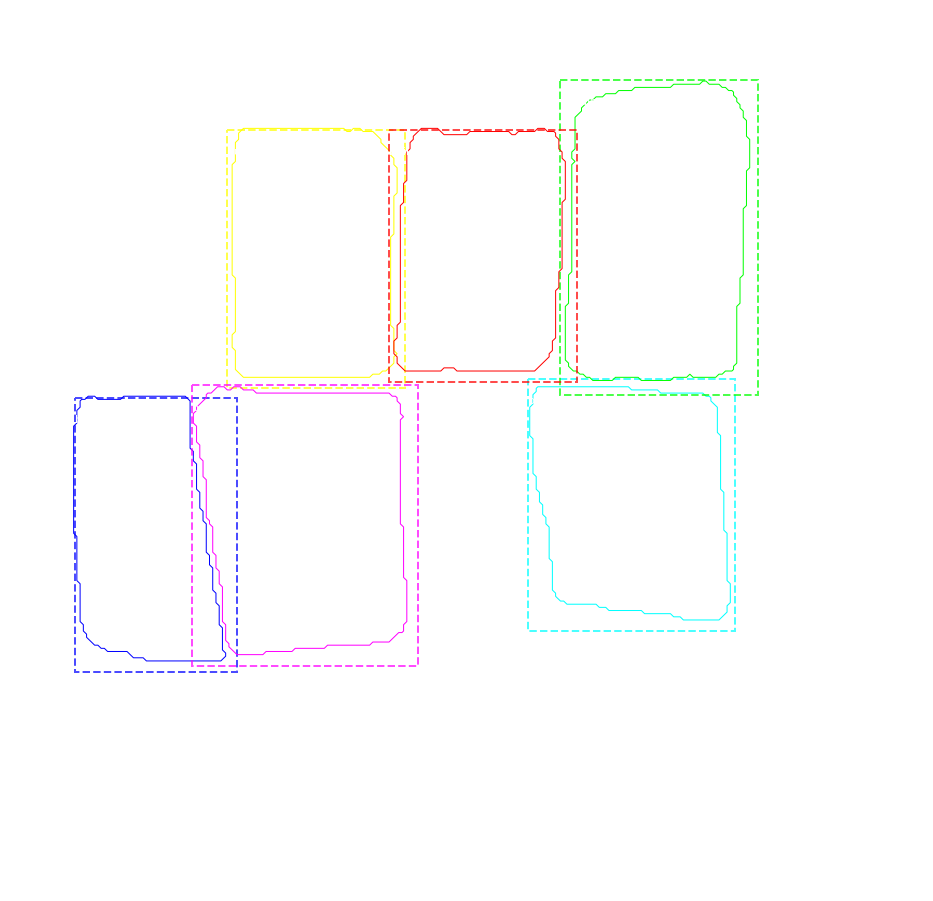

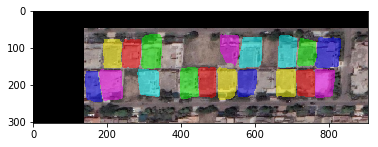

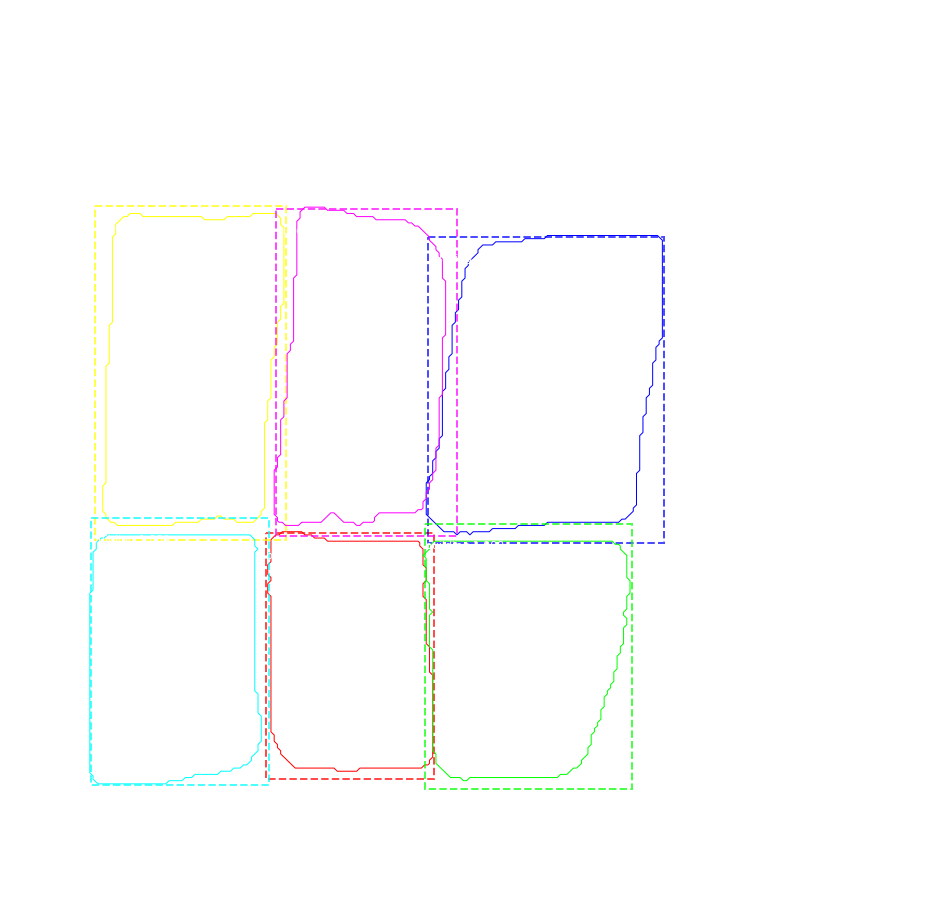

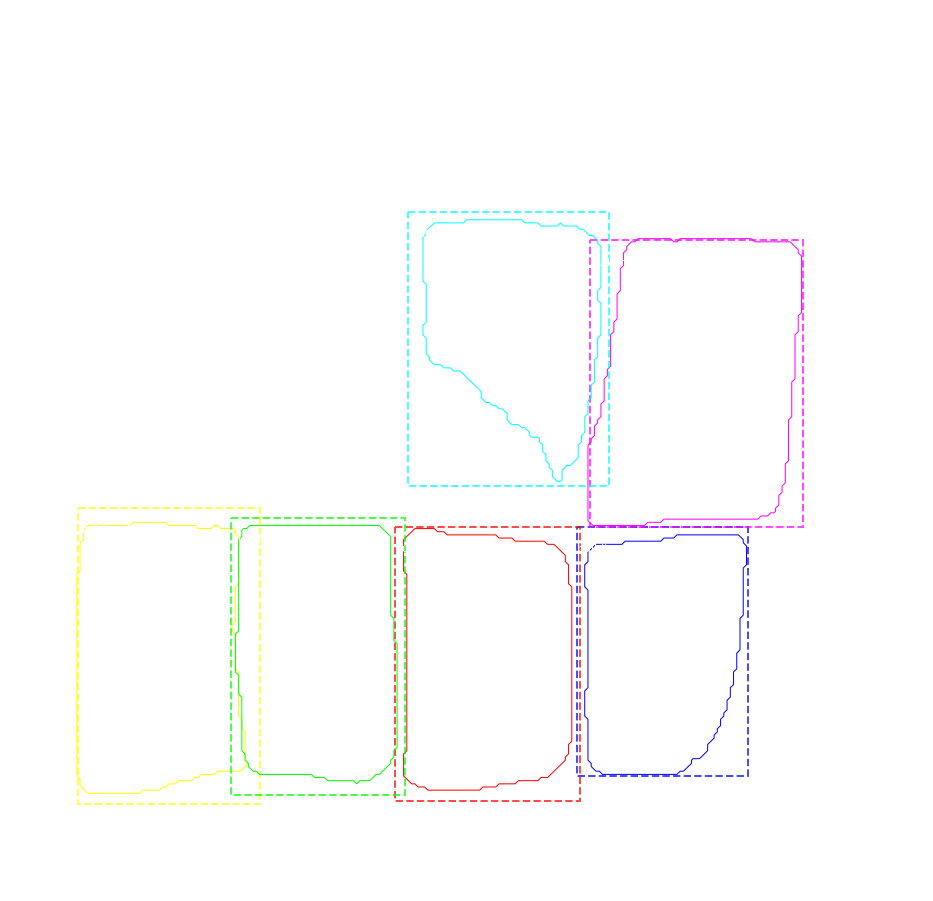

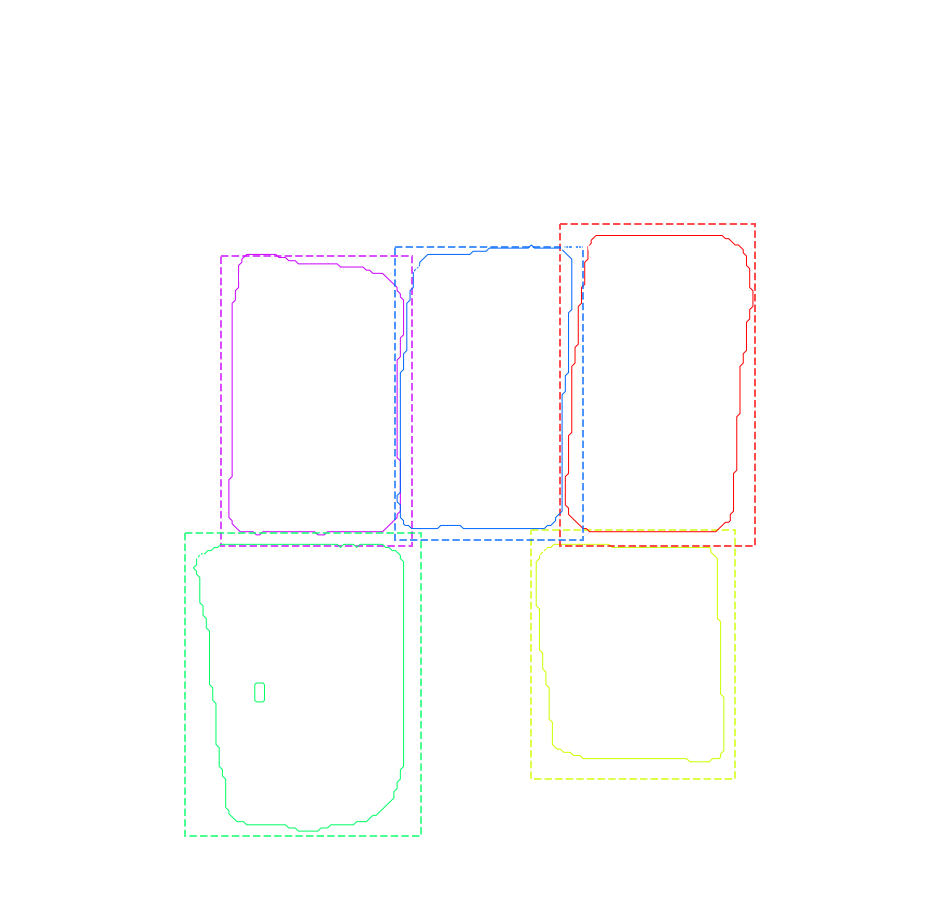

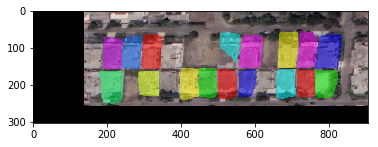

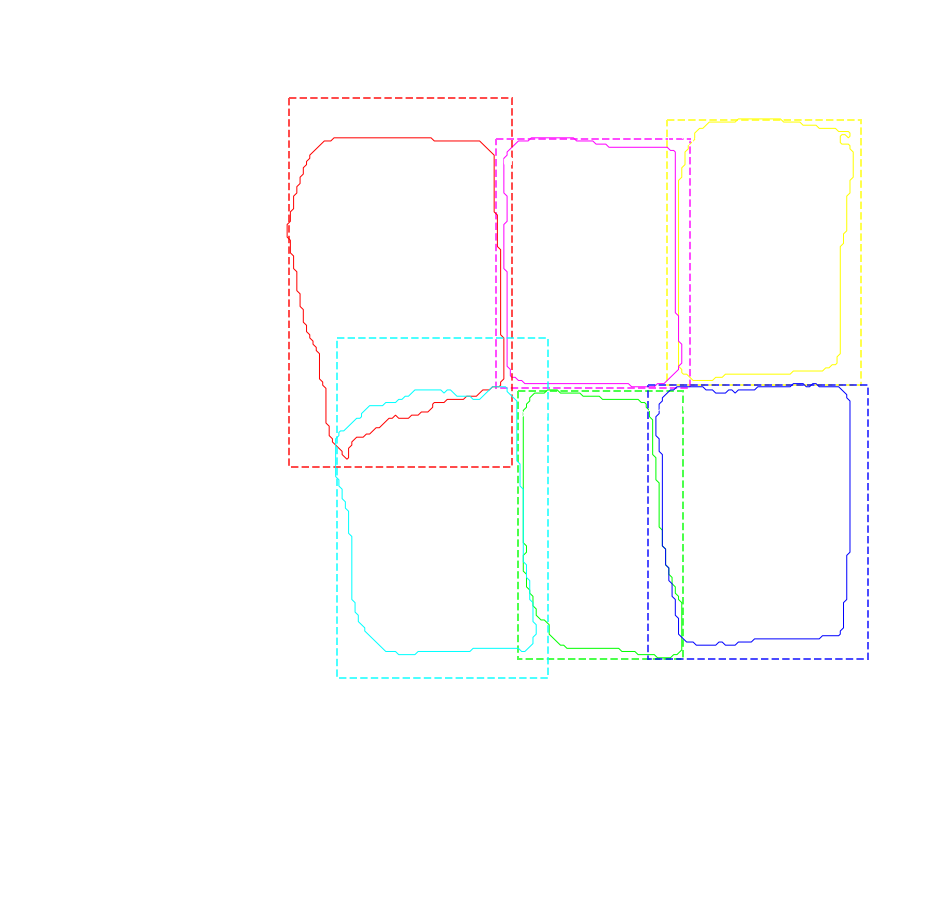

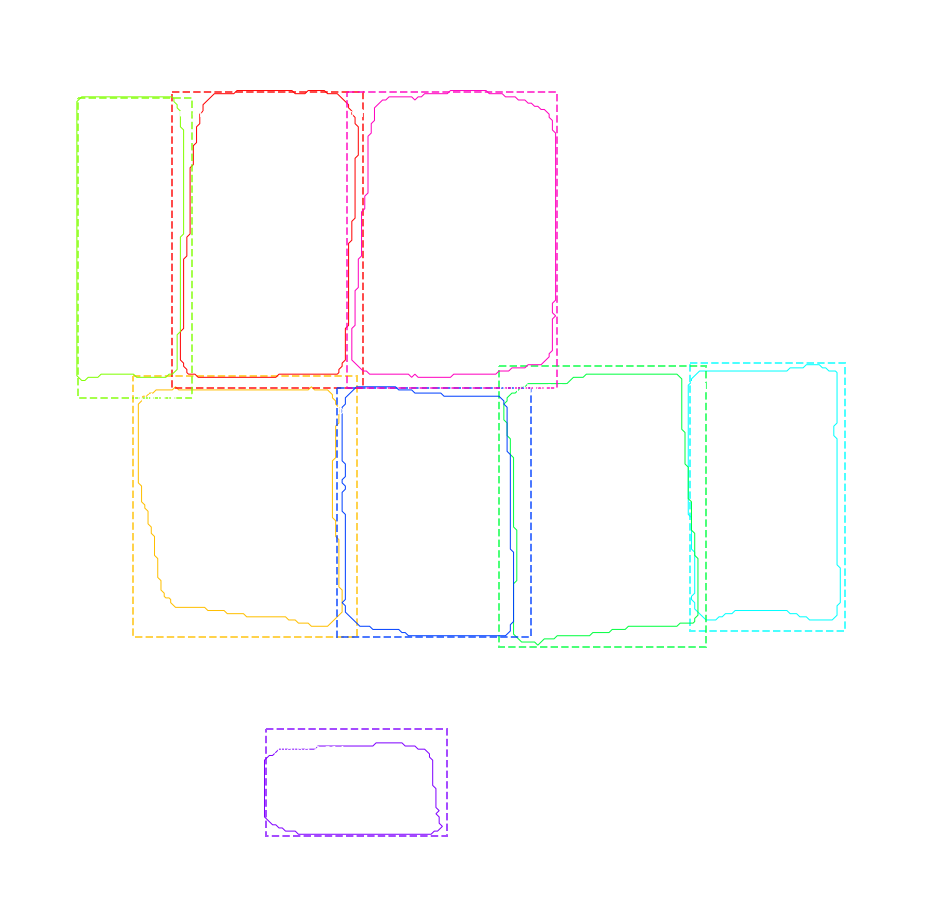

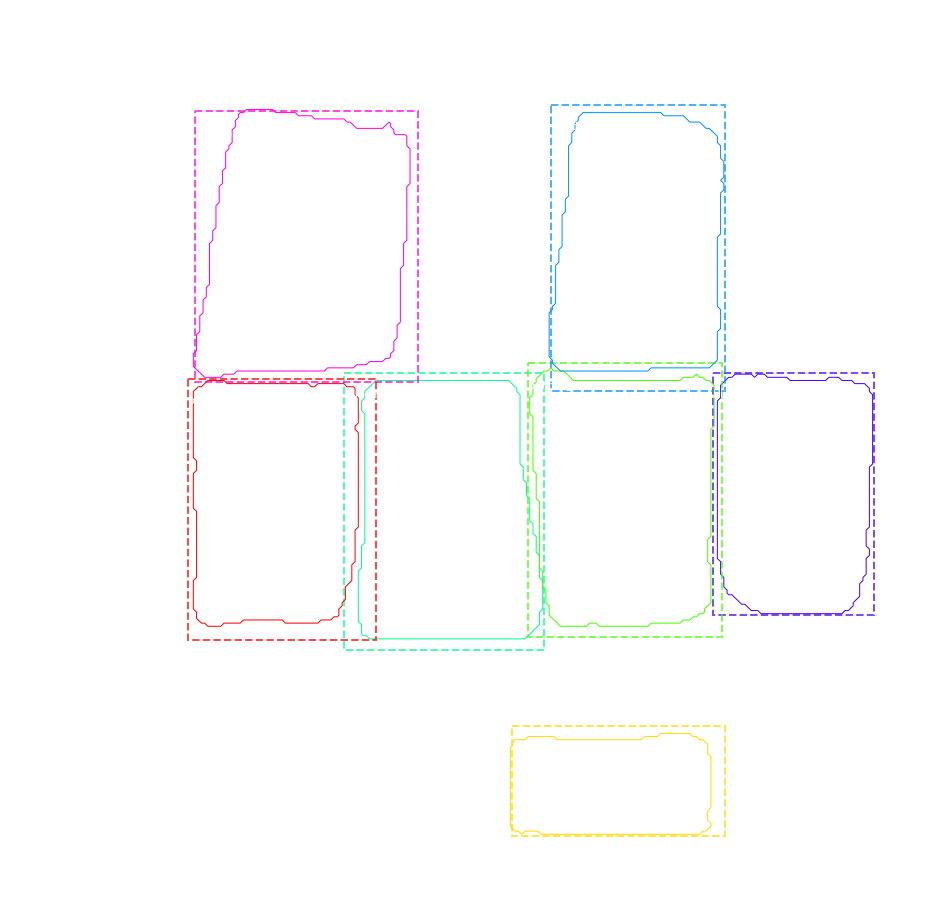

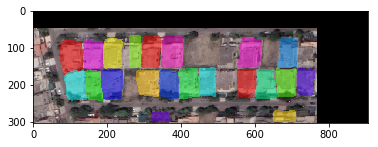

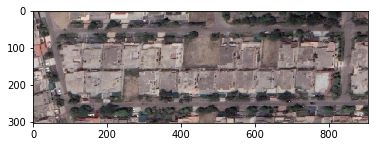

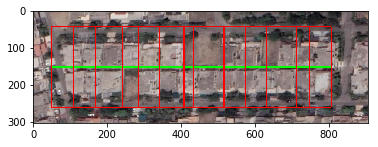

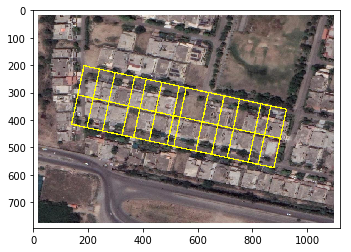

In [10]:
#Opening JSON file
#name of the kml file and folder containing extracted block images needs to be same
region = "suigas"
path = "data/" + region
f = open(path +'/data.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)

#for storing evaluation stats
total_boxes = 0
total_anns = 0
total_iou = 0

#convert json to array
keys = []
for k in data: 
    keys.append(k)


#for evaluation
annFile='./data/ground_truth/'+region+'-gt/'+region+'-gt-coco.json'
coco=COCO(annFile)
imgIds = coco.getImgIds()
ann_imgs = coco.loadImgs(imgIds)

#for storing results in KML
kml = simplekml.Kml()

for key in keys:
    print(key)
    
    
    img_path = path + "/{}".format(key)
    image = skimage.io.imread(os.path.join(ROOT_DIR, img_path))
#     image = cv2.imread(os.path.join(ROOT_DIR, img_path))

    #extracting all polygon points
    points = data[key]["points"]
    points_arr = np.asarray(points, dtype=np.int32)
    
    imgheight=image.shape[0]
    imgwidth=image.shape[1]
    
    isClosed = True
    
    
    #getting major axis of the polygon
    poly = Polygon(points)
    mbr_points = list(zip(*poly.minimum_rotated_rectangle.exterior.coords.xy))
    
    side1 = distance(mbr_points[0],mbr_points[1])
    side2 = distance(mbr_points[1],mbr_points[2])
    
    if side1 > side2:
        point1 = mbr_points[0]
        point2 = mbr_points[1]
    else:
        point1 = mbr_points[1]
        point2 = mbr_points[2]
        
    major_axis_points = [point1,point2]
    major_axis_points = [list(x) for x in major_axis_points]
    
    #get rotated image and rotation angle
    r_image, a, b, rotation_angle = getRotatedImageAndDividingLine(image, point1, point2)
    
    rotated_points = [rotate_point(image, x, rotation_angle) for x in points]
    rotated_major_axis_points = [rotate_point(image, x, rotation_angle) for x in major_axis_points]
    
    plt.figure()
    
    rotated_points = np.asarray(rotated_points, dtype=np.int32)
    
    #set bounding rectangle around the polygon and get cropped image of the block with additonal padding = thresh
    rect = cv2.boundingRect(rotated_points)
    x,y,w,h = rect

    thresh = 50
    a = (thresh, int(h/2) + thresh)
    b = (w, int(h/2) + thresh)
    cropped = r_image[y-thresh:y+h+thresh, x-thresh:x+w+thresh].copy()
    
    #run Mask-RCNN prediction on the cropped image to get masks and average width and height
    w, l, masks = getFourDirectionData(cropped)
    
    if len(masks) == 0:
        continue
        
    #estimate grid on the image based on the stats
    grid_boxes = estimateGrid(key, cropped, w, l, masks, a, b)
    
    #get geo-coordinates of the polygon extent
    lb_latlng = data[key]["geo_extent"][0] 
    rb_latlng = data[key]["geo_extent"][1]
    lt_latlng = data[key]["geo_extent"][2]
    rt_latlng = data[key]["geo_extent"][3]
    
    #for conversion from pixel space to geo space
    lon_center = lb_latlng[0] + (lt_latlng[0] - lb_latlng[0])/2
    lat_center = lt_latlng[1] + (rt_latlng[1] - lt_latlng[1])/2
    
    
    #fetch all annotations for this image
    res = list(filter(lambda x: x['file_name'] == key, ann_imgs))[0]
    annIds = coco.getAnnIds(imgIds=res['id'], iscrowd=None)
    anns = coco.loadAnns(annIds)
    
    plt.figure()
    
    for box in grid_boxes:
        pol = kml.newpolygon(name='box_'+str(key))
        
        p0 = (box[0][0] + x-thresh, box[0][1] + y-thresh)
        p1 = (box[1][0] + x-thresh, box[1][1] + y-thresh)
        p2 = (box[2][0] + x-thresh, box[2][1] + y-thresh)
        p3 = (box[3][0] + x-thresh, box[3][1] + y-thresh)
        
        angle = rotation_angle
        
        cp0 = rotate_point_inverse(image, p0, angle)
        cp1 = rotate_point_inverse(image, p1, angle)
        cp2 = rotate_point_inverse(image, p2, angle)
        cp3 = rotate_point_inverse(image, p3, angle)
        
        gp0 = rotate_point_inverse(image, p0, angle)
        gp1 = rotate_point_inverse(image, p1, angle)
        gp2 = rotate_point_inverse(image, p2, angle)
        gp3 = rotate_point_inverse(image, p3, angle)
        
        zoom = 18.80
#         zoom = 19.30
        geo_p0 = xy2LatLon(lat_center,lon_center, zoom, 1122, 794, gp0[0], gp0[1])
        geo_p1 = xy2LatLon(lat_center,lon_center, zoom, 1122, 794, gp1[0], gp1[1])
        geo_p2 = xy2LatLon(lat_center,lon_center, zoom, 1122, 794, gp2[0], gp2[1])
        geo_p3 = xy2LatLon(lat_center,lon_center, zoom, 1122, 794, gp3[0], gp3[1])
        
        cv2.line(image,cp0,cp1,(255,255,0),3)
        cv2.line(image,cp1,cp2,(255,255,0),3)
        cv2.line(image,cp2,cp3,(255,255,0),3)
        cv2.line(image,cp3,cp0,(255,255,0),3)
        
        #saving polygon in KML 
        pol.outerboundaryis = [(geo_p2[1], geo_p2[0]), 
                               (geo_p3[1], geo_p3[0]),
                               (geo_p0[1], geo_p0[0]),(geo_p1[1], geo_p1[0]),(geo_p2[1], geo_p2[0])]
    
        pol.style.linestyle.color = simplekml.Color.green
        pol.style.linestyle.width = 1
        pol.style.polystyle.color = simplekml.Color.changealphaint(100, simplekml.Color.green)
        
        
        #for evalutaion
        iou_arr = []
    
        for ann in anns:
            mask = coco.annToMask(ann)

            mask_img = mask.astype(np.uint8)
            ret, threshold = cv2.threshold(mask_img, 0, 1, 0)
            contours = cv2.findContours(threshold, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
            
            if contours:
                cnt = contours[1]

                rect = cv2.minAreaRect(cnt[0])
                rect_box = cv2.boxPoints(rect)
                rect_box = np.int0(rect_box)

                tuple_box = []

                for i in range(len(rect_box)):
                    tuple_box.append((rect_box[i][0], rect_box[i][1]))
            
                a = Polygon(tuple_box)
                b = Polygon([cp0, cp1, cp2, cp3])
                    
                iou_arr.append((a.intersection(b).area)/(a.union(b).area))
        
    
        total_iou += max(iou_arr) if len(iou_arr) > 0 else 0.0
        
        
        
    plt.imshow(image)
    
    total_boxes += len(grid_boxes)
    total_anns += len(anns)
    
    
kml.save(region + ".kml")


print("total_boxes")
print(total_boxes)

print("total_anns")
print(total_anns)

print("total_iou")
print(total_iou)

print("average_iou")
print(total_iou/total_anns)
    
    
f.close()

# Evaluation

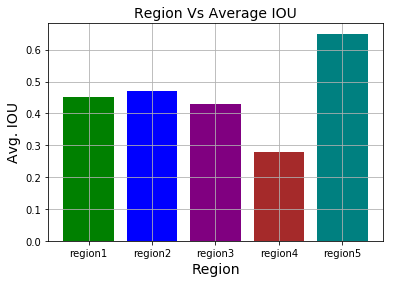

In [12]:
Region = ['region1','region2','region3','region4','region5']
GDP_Per_Capita = [0.45,0.47,0.43,0.28,0.65]

New_Colors = ['green','blue','purple','brown','teal']
plt.bar(Region, GDP_Per_Capita, color=New_Colors)
plt.title('Region Vs Average IOU', fontsize=14)
plt.xlabel('Region', fontsize=14)
plt.ylabel('Avg. IOU', fontsize=14)
plt.grid(True)
plt.show()

Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  148.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32
Processing 1 images
image                    shape: (256, 256, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  float64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


47
426
384
342
300
258
216
174
132
90
48
Cost before line adjustment: 
142
Cost After line adjustment: 
0
[406, 360, 300, 258, 210, 153, 101, 48]


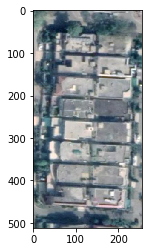

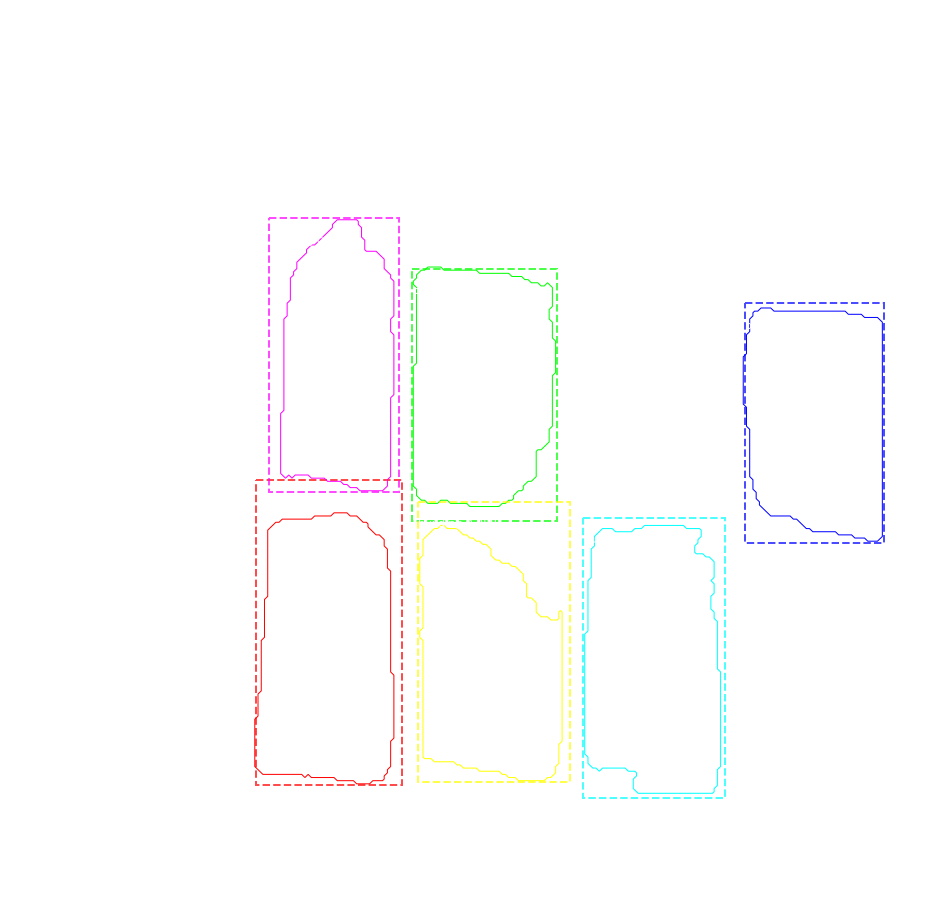

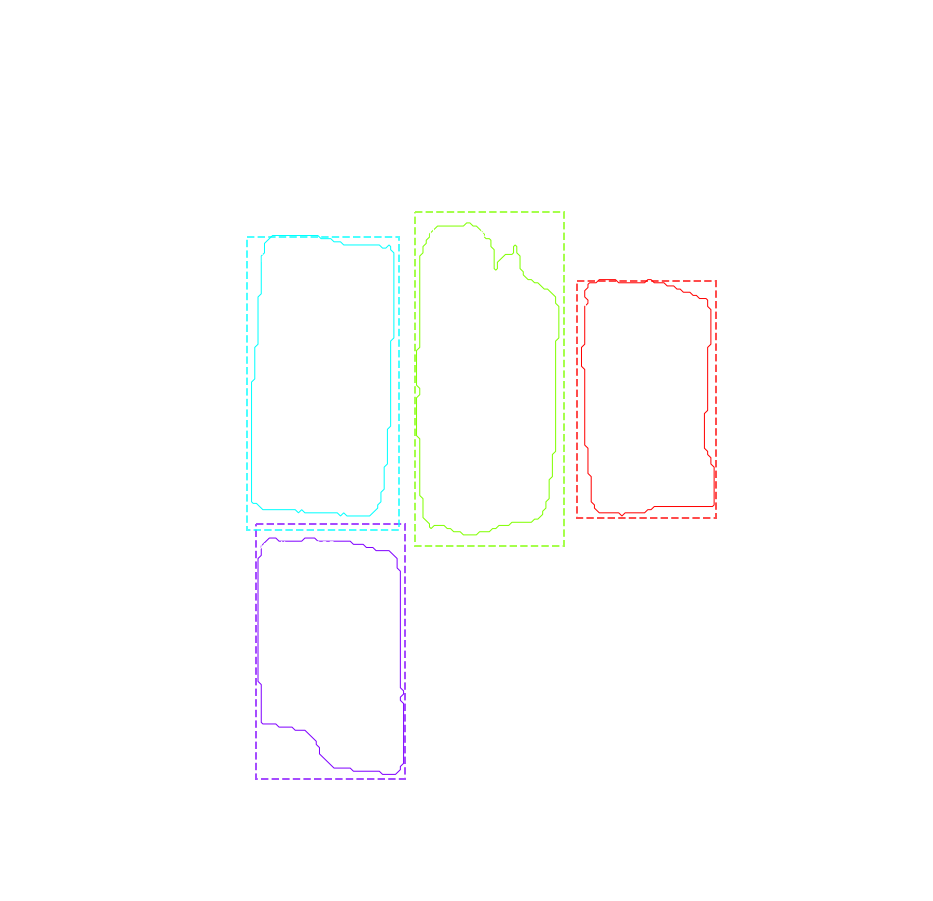

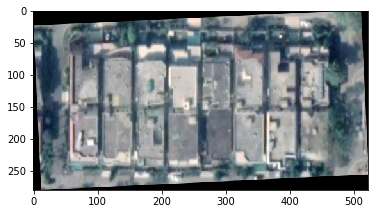

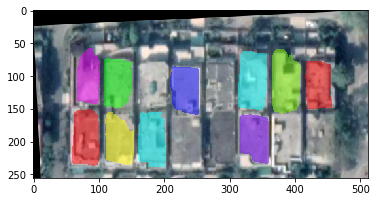

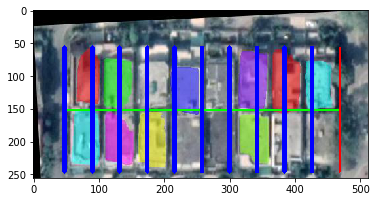

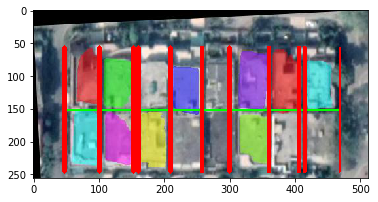

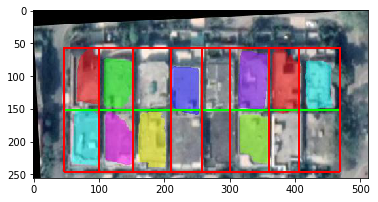

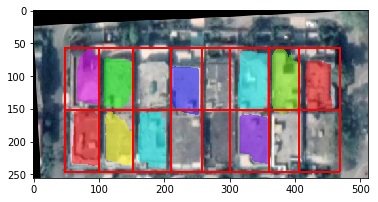

In [103]:
file_name = "block1"
img_org = skimage.io.imread("./data/test_data/"+file_name+".jpg")

a = (130, 470)
b = (150, 50)

plt.figure()
plt.imshow(img_org)


r_image, a, b, rotation_angle = getRotatedImageAndDividingLine(img_org, a, b)

w, l, masks, r_image = getRotatedImageData(r_image, file_name)

grid_boxes = estimateGrid(file_name, r_image, w, l, masks, a, b)


#generate Masks
for box in grid_boxes:
    cv2.line(r_image,box[0],box[1],(255,0,0),2)
    cv2.line(r_image,box[1],box[2],(255,0,0),2)
    cv2.line(r_image,box[2],box[3],(255,0,0),2)
    cv2.line(r_image,box[3],box[0],(255,0,0),2)
    
plt.figure()
plt.imshow(r_image)

# Validation

In [70]:
annFile='./data/ground_truth/f11-gt/f11-gt-coco.json'
coco=COCO(annFile)

cats = coco.loadCats(coco.getCatIds())
nms=[cat['name'] for cat in cats]
print('COCO categories: \n{}\n'.format(' '.join(nms)))

nms = set([cat['supercategory'] for cat in cats])
print('COCO supercategories: \n{}'.format(' '.join(nms)))

catIds = coco.getCatIds(catNms=['building'])
imgIds = coco.getImgIds(catIds=catIds );
print(imgIds)
imgIds = coco.getImgIds(imgIds)


ann_img = coco.loadImgs(imgIds)
# print(ann_img)

res = list(filter(lambda x: x['file_name'] == 'block_4.jpg', ann_img))
print(res)


annIds = coco.getAnnIds(imgIds=res[0]['id'], catIds=catIds, iscrowd=None)
anns = coco.loadAnns(annIds)

print(anns)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
COCO categories: 
building

COCO supercategories: 
building
[1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 29, 31, 32, 33, 34, 35]
[{'file_name': 'block_4.jpg', 'date_captured': '', 'license': 0, 'width': 1122, 'height': 794, 'id': 4}]
[{'segmentation': [[99, 505, 168, 604, 243, 567, 170, 467]], 'image_id': 4, 'bbox': [99, 467, 144, 137], 'iscrowd': 0, 'category_id': 1, 'area': 19728, 'id': 61}, {'segmentation': [[172, 608, 260, 711, 328, 672, 245, 571]], 'image_id': 4, 'bbox': [172, 571, 156, 140], 'iscrowd': 0, 'category_id': 1, 'area': 21840, 'id': 62}, {'segmentation': [[246, 567, 311, 531, 231, 430, 174, 462]], 'image_id': 4, 'bbox': [174, 430, 137, 137], 'iscrowd': 0, 'category_id': 1, 'area': 18769, 'id': 63}, {'segmentation': [[237, 429, 314, 528, 375, 500, 287, 396]], 'image_id': 4, 'bbox': [237, 396, 138, 132], 'iscrowd': 0, 'category_id': 1, 'area': 18216,

<built-in function len>


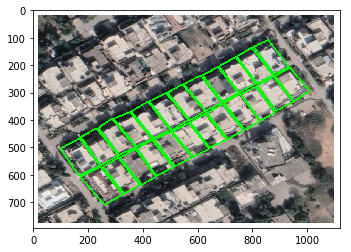

In [71]:
print(len)

img = skimage.io.imread("./data/ground_truth/f11-gt/block_4.jpg")

for ann in anns:
#     print(ann)
#     ann_img = coco.loadImgs(ann['image_id'])
    
    
    
    mask = coco.annToMask(ann)
    
    mask_img = mask.astype(np.uint8)
    ret, thresh = cv2.threshold(mask_img, 0, 1, 0)
    contours = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    
    cv2.drawContours(img,contours[1],0,(0,255,0),5)
#     rect = cv2.minAreaRect(cnt)

#     box = []

#     if contours:
#         cnt = contours[1]
# #         print(cnt)
        
#         rect = cv2.minAreaRect(cnt[0])
#         box = cv2.boxPoints(rect)
#         box = np.int0(box)
        
#         tuple_box = []

#         for i in range(len(box)):
#             tuple_box.append((box[i][0], box[i][1]))
            
# #         print(tuple_box)

#         drawMasks(img, [box])
        
    
#     gt = Polygon(tuple_box)
#     b = Polygon([(2, 2), (6, 3), (5, 7), (1, 6)])
        
    

#     ann_bbox = getBoundingBoxCoordinates(ann['bbox'])
        
#     cv2.line(img,ann_bbox[0],ann_bbox[1],(255,255,0),2)
#     cv2.line(img,ann_bbox[1],ann_bbox[2],(255,255,0),2)
#     cv2.line(img,ann_bbox[2],ann_bbox[3],(255,255,0),2)
#     cv2.line(img,ann_bbox[3],ann_bbox[0],(255,255,0),2)

plt.imshow(img)


[155, 60, 81, 48]
[409  58 464 153]
[406  57 468 152]
0.8715596330275229


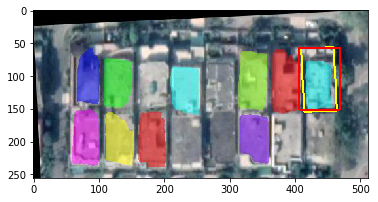

In [7]:
test_img = skimage.io.imread("./rotated_results/"+ file_name +".jpg")

I = skimage.io.imread(os.path.join(ROOT_DIR, "annotations" ,ann_img['file_name']))
bbox = getBoundingBoxCoordinates(anns[0]['bbox'])
print(anns[1]['bbox'])


r_bbox = rotatebbox(img_org, rotation_angle, bbox)


cv2.line(test_img,r_bbox[0],r_bbox[1],(255,255,0),2)
cv2.line(test_img,r_bbox[1],r_bbox[2],(255,255,0),2)
cv2.line(test_img,r_bbox[2],r_bbox[3],(255,255,0),2)
cv2.line(test_img,r_bbox[3],r_bbox[0],(255,255,0),2)

pred_bbox = grid_boxes[1]
cv2.line(test_img,pred_bbox[0],pred_bbox[1],(255,0,0),2)
cv2.line(test_img,pred_bbox[1],pred_bbox[2],(255,0,0),2)
cv2.line(test_img,pred_bbox[2],pred_bbox[3],(255,0,0),2)
cv2.line(test_img,pred_bbox[3],pred_bbox[0],(255,0,0),2)


r_bbox = np.array([list(min(r_bbox)), list(max(r_bbox))]).flatten()
pred_bbox = np.array([list(min(pred_bbox)), list(max(pred_bbox))]).flatten()

print(r_bbox)
print(pred_bbox)

iou = bb_intersection_over_union(r_bbox, pred_bbox)


print(iou)
plt.figure()
plt.imshow(test_img)

(437, 199)
0.70843776106934
(437, 104)
0.8715596330275229
(383, 199)
0.8219289340101523
(383, 104)
0.7937477542220626
(330, 199)
0.7896462467644522
(330, 104)
0.8384970336189849
(279, 199)
0.7549949545913219
(279, 104)
0.7226890756302521
(234, 199)
0.8149720239243681
(234, 104)
0.784
(181, 199)
0.8436505129112133
(181, 104)
0.8810333106730116
(127, 199)
0.8950297447706774
(127, 104)
0.8396039603960396
(74, 199)
0.8584440227703984
(74, 104)
0.8854633446854275


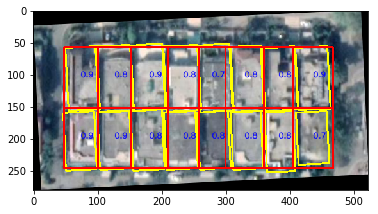

In [8]:
def writeIOU(image, point, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 0.4
    color = (0, 0, 255)
    thickness = 1
    cv2.putText(image, text, point, font, fontScale, color, thickness, cv2.LINE_AA)


img = rotate_bound(img_org, -1*rotation_angle)

for ann in anns:
    ann_bbox = getBoundingBoxCoordinates(ann['bbox'])
    r_bbox = rotatebbox(img_org, rotation_angle, ann_bbox)
        
    cv2.line(img,r_bbox[0],r_bbox[1],(255,255,0),2)
    cv2.line(img,r_bbox[1],r_bbox[2],(255,255,0),2)
    cv2.line(img,r_bbox[2],r_bbox[3],(255,255,0),2)
    cv2.line(img,r_bbox[3],r_bbox[0],(255,255,0),2)
    

for box in grid_boxes:
    iou_arr = []
    pred_bbox = box
        
    cv2.line(img,pred_bbox[0],pred_bbox[1],(255,0,0),2)
    cv2.line(img,pred_bbox[1],pred_bbox[2],(255,0,0),2)
    cv2.line(img,pred_bbox[2],pred_bbox[3],(255,0,0),2)
    cv2.line(img,pred_bbox[3],pred_bbox[0],(255,0,0),2)
    
    pred_bbox = np.array([list(min(pred_bbox)), list(max(pred_bbox))]).flatten()
    
    for ann in anns:
        ann_bbox = getBoundingBoxCoordinates(ann['bbox'])
        r_bbox = rotatebbox(img_org, rotation_angle, ann_bbox)
        r_bbox = np.array([list(min(r_bbox)), list(max(r_bbox))]).flatten()
        
        iou_arr.append(bb_intersection_over_union(r_bbox, pred_bbox))
        
    iou = max(iou_arr)
    
    
    point = (int(pred_bbox[0] + (pred_bbox[2] - pred_bbox[0])/2), int(pred_bbox[1] + (pred_bbox[3] - pred_bbox[1])/2))
    print(point)
    
    print(iou)
    
    writeIOU(img, point, str(round(iou,1)))

plt.imshow(img)
    